# Deep Learning Training Flow
- Create our own sample data
- Construct a multilayer neural network classifier
- Select optimizer and loss function
- Train
- Evaluate 
- Set up hyperparameter tuning

In [18]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [23]:
print("PyTorch version:", torch.__version__)
print("GPU Available:", torch. cuda. is_available())
# print(torch.cuda.device_count())
cuda_ = "cuda:0"
device = torch.device(cuda_ if torch.cuda.is_available() else "cpu")

PyTorch version: 2.3.0
GPU Available: True


### Mock data generation
- X: 2D cartesian data
    - x,y coordinates
- Labels:
    - "1" if point inside a circle with radius 0.5
    - "0" if point is outside circle
 
Data should be stratified for best training results, meaning there should be an approximately even number of data points representing "0" and "1" labels.

In [3]:
def create_mock_data(n_records: int, n_features: int) -> Tuple[np.ndarray, np.ndarray]:

    def _is_inside_circle(_x: np.ndarray) -> int:
        if np.sqrt(np.sum(np.square(_x))) < 0.5:
            return 1
        else:
            return 0
    
    _x = (np.random.random(size=(n_records, n_features)) - 0.5)
    _labels = np.apply_along_axis(_is_inside_circle, axis=1, arr=_x)

    return _x, _labels

In [4]:
x, labels = create_mock_data(10000, 2)

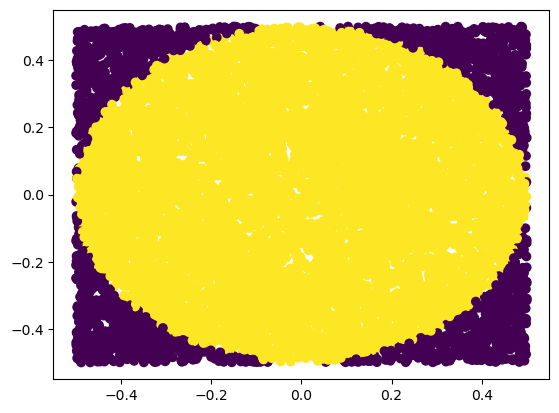

In [5]:
plt.scatter(x=x[:, 0], y=x[:, 1], c=labels)

In [6]:
def stratified_sample(_x: np.ndarray, _labels: np.ndarray, n_each: int) -> Tuple[np.ndarray, np.ndarray]:
    unique_labels = np.unique(_labels)
    row_indices = np.arange(_x.shape[0])
    sample_x = []
    sample_labels = []
    for unique_label in unique_labels:
        _idx = np.random.choice(row_indices[np.where(_labels == unique_label)], size=n_each, replace=False)
        sample_x.append(_x[_idx])
        sample_labels.append(_labels[_idx])
        
    return np.concatenate(sample_x), np.concatenate(sample_labels)

In [7]:
def create_stratified_mock_data(n_records: int, n_features: int):
    pool_x, pool_labels = create_mock_data(n_records=10*n_records, n_features=n_features)
    return stratified_sample(pool_x, pool_labels, n_each=n_records//2) 

In [8]:
x, labels = create_stratified_mock_data(n_records=200, n_features=2)

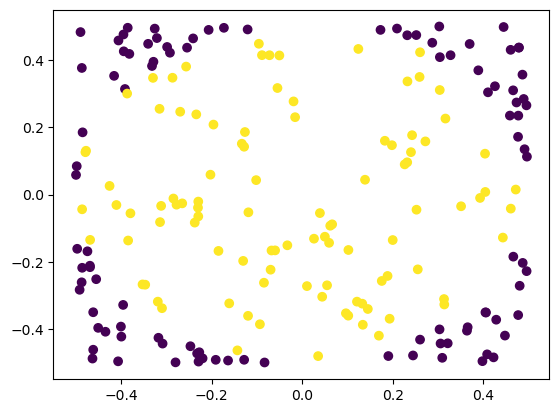

In [9]:
plt.scatter(x=x[:, 0], y=x[:, 1], c=labels)

### Create Pytorch data sets for training and validation

In [10]:
class MockDataset(Dataset):

    def __init__(self, x: np.ndarray, labels: np.ndarray):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.labels = torch.tensor(labels)

    def __getitem__(self, index):
        return self.x[index], self.labels[index]

    def __len__(self):
        return self.x.shape[0]

In [11]:
n_features = 2
training_data_set = MockDataset(*create_stratified_mock_data(n_records=10000, n_features=n_features))
validation_data_set = MockDataset(*create_stratified_mock_data(n_records=500, n_features=n_features))

### Classification Model
- linear neural network
- variable number of hidden layers and number of nodes per hidden layer
- relu activation
- optional batch normalization

In [12]:
class MLP(nn.Module):

    def __init__(self, n_features: int, n_hidden_layers: int, nodes_per_layer: int, include_batch_norm: bool, device: torch.device):
        super().__init__()
        self.include_batch_norm = include_batch_norm
        self.input_layer = nn.Linear(n_features, nodes_per_layer).to(device)
        self.hidden_layers = [nn.Linear(nodes_per_layer, nodes_per_layer).to(device) for _ in range(n_hidden_layers)]
        if include_batch_norm:
            self.batch_norms = [nn.BatchNorm1d(nodes_per_layer).to(device) for _ in range(n_hidden_layers)]
        self.output_layer = nn.Linear(nodes_per_layer, 2).to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_layer(x)
        x = torch.relu(x)
        for i in range(len(self.hidden_layers)):
            x = self.hidden_layers[i](x)
            if self.include_batch_norm:
                x = self.batch_norms[i](x)
            x = torch.relu(x)
        x = self.output_layer(x)
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        y = self(x)
        probs = torch.softmax(input=y, dim=1)
        _, labels = torch.max(probs, dim=1)
        return labels

### Compute Validation Loss

In [13]:
def compute_dataset_loss(model: nn.Module, loss_function: nn.Module, dataset: Dataset, device: torch.device):
    """
    Compute loss of model for complete dataset in eval mode (no gradients)
    """
    model.eval()

    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=500)
        cumulative_loss = 0.0
        for x, labels in data_loader:
            x, labels = x.to(device).float(), labels.to(device).long()
            y_hat = model(x)
            cumulative_loss += loss_function(y_hat, labels).item()

    model.train()

    return cumulative_loss / len(dataset)

In [14]:
def compute_dataset_confusion_matrix(model: nn.Module, dataset: Dataset, device: torch.device):
    """
    Create a confusion matrix on the dataset in eval mode (no gradients)
    """

    model.eval()

    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=500)
        actual = []
        predicted = []
        for x, labels in data_loader:
            x = x.to(device)
            labels_pred = model.predict(x)
            actual.append(labels.cpu().numpy())
            predicted.append(labels_pred.cpu().numpy())
    model.train()

    actual = np.concatenate(actual)
    predicted = np.concatenate(predicted)

    return confusion_matrix(actual, predicted)

### Training Loop

In [15]:
def train(epochs: int, 
          learning_rate,
          batch_size,
          n_hidden_layers, 
          nodes_per_layer, 
          include_batch_norm, 
          eval_every) -> nn.Module:

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = MLP(n_features, n_hidden_layers, nodes_per_layer, include_batch_norm, device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    data_loader = DataLoader(training_data_set, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for x, labels in data_loader:
            x, labels = x.to(device).float(), labels.to(device).long()  # Ensure x is Float and labels are Long
            optimizer.zero_grad()
            y_hat = model(x)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()

        if epoch % eval_every == 0:
            validation_loss = compute_dataset_loss(model, loss_function, validation_data_set, device)
            print(f"Epoch: {epoch} --- validation loss: {validation_loss}")

    print(compute_dataset_confusion_matrix(model, validation_data_set, device))

    return model

In [16]:
_ = train(epochs=10, 
          learning_rate=0.01,
          batch_size=32,
          n_hidden_layers=2,
          nodes_per_layer=4, 
          include_batch_norm=False,
          eval_every=1)

Epoch: 0 --- validation loss: 0.0013163487911224366
Epoch: 1 --- validation loss: 0.0012064849138259887
Epoch: 2 --- validation loss: 0.0011371837854385375
Epoch: 3 --- validation loss: 0.0011062506437301636
Epoch: 4 --- validation loss: 0.001074217915534973
Epoch: 5 --- validation loss: 0.0010531080961227418
Epoch: 6 --- validation loss: 0.0010424320697784424
Epoch: 7 --- validation loss: 0.0010270357131958007
Epoch: 8 --- validation loss: 0.0010198410749435425
Epoch: 9 --- validation loss: 0.0010152838230133056
[[173  77]
 [ 38 212]]


In [17]:
_ = train(epochs=10, 
          learning_rate=0.01,
          batch_size=32,
          n_hidden_layers=2,
          nodes_per_layer=4, 
          include_batch_norm=True,
          eval_every=1)

Epoch: 0 --- validation loss: 0.0009735224246978759
Epoch: 1 --- validation loss: 0.0006975035071372986
Epoch: 2 --- validation loss: 0.00047050368785858155
Epoch: 3 --- validation loss: 0.0004805299639701843
Epoch: 4 --- validation loss: 0.0004647218883037567
Epoch: 5 --- validation loss: 0.0004533144533634186
Epoch: 6 --- validation loss: 0.0004558968245983124
Epoch: 7 --- validation loss: 0.00044046106934547425
Epoch: 8 --- validation loss: 0.000493979036808014
Epoch: 9 --- validation loss: 0.00045670253038406373
[[237  13]
 [ 35 215]]
